# Ticket Classification Case Study

In [6]:
%pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... one
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=5a07602c9ddb7a4a1b26db08d74e955fcd71d9240f38bb0fe6a4a8cec5f0a65f
  Stored in directory: /Users/rohitagg/Library/Caches/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter
Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.7/171.7 kB 2.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Import all the necessary libraries
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string, random
import seaborn as sns
import swifter
from pprint import pprint

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Print python, jupyter and all the imported library versions
import sys
import jupyter_core
import matplotlib
import sklearn
import plotly
import wordcloud

print("python : {0}".format(sys.version))
print("jupyter : {0}".format(jupyter_core.__version__))
print("numpy : {0}".format(np.__version__))
print("pandas : {0}".format(pd.__version__))
print("matplotlib : {0}".format(matplotlib.__version__))
print("seaborn : {0}".format(sns.__version__))
print("plotly : {0}".format(plotly.__version__))
print("wordcloud : {0}".format(wordcloud.__version__))
print("nltk : {0}".format(nltk.__version__))
print("spacy : {0}".format(spacy.__version__))
print("sklearn : {0}".format(sklearn.__version__))

python : 3.11.7 (main, Dec 15 2023, 12:09:04) [Clang 14.0.6 ]
jupyter : 5.5.0
numpy : 1.24.4
pandas : 1.5.3
matplotlib : 3.8.0
seaborn : 0.13.2
plotly : 5.9.0
wordcloud : 1.9.4
nltk : 3.8.1
spacy : 3.8.4
sklearn : 1.2.2


In [12]:
# Download wordnet and punkt libraries on nltk
nltk.download('wordnet')
nltk.download('punkt')

# Load the english core web small
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rohitagg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/rohitagg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Understanding

In [19]:
# Prepare path to the json file and open the same
file_path = "complaints-2021-05-14_08_16.json"
file = open(file_path, "r", encoding="utf-8")

# Load data as a JSON object and prepare dataframe using it
data = json.load(file)
df = pd.json_normalize(data)

In [20]:
# Create a method to print the shape of data frame along with first 5 rows
def print_shape_and_5rows(df):
    print("Shape = {}".format(df.shape))
    return df.head(5)

In [21]:
# Create a method to print the shape of data frame along with column names
def print_shape_and_columns(df):
    print("Shape = {}".format(df.shape))
    print("Columns = {}".format(df.columns))

In [25]:
# Inspect the dataframe to understand the given data
print_shape_and_5rows(df)

Shape = (78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [27]:
# Print the information about the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [29]:
# Print the column names of the data frame
print_shape_and_columns(df)

Shape = (78313, 22)
Columns = Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


# Data Cleaning

In [32]:
# Assign new column names
df = df.rename(columns={
    "_index": "index", "_type": "type", "_id": "id", "_score": "score", "_source.tags": "tags", "_source.zip_code": "zip_code", 
    "_source.complaint_id": "complaint_id", "_source.issue": "issue", "_source.date_received": "date_recevied", "_source.timely": "timely",
    "_source.state": "state", "_source.consumer_disputed": "disputed", "_source.product": "product", "_source.company": "company",
    "_source.company_response": "company_response", "_source.submitted_via": "submitted_via", "_source.sub_product": "sub_product",
    "_source.date_sent_to_company": "date_sent_to_company", "_source.company_public_response": "company_public_response",
    "_source.complaint_what_happened": "complaint", "_source.consumer_consent_provided": "consent_provided",
    "_source.sub_issue": "sub_issue"})
print_shape_and_columns(df)

Shape = (78313, 22)
Columns = Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_recevied', 'state', 'disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely', 'complaint',
       'sub_issue', 'consent_provided'],
      dtype='object')


In [34]:
# Assign nan in place of blanks in the complaints column
df["complaint"] = df["complaint"].replace("", np.nan)
print_shape_and_5rows(df)

Shape = (78313, 22)


,index,type,id,score,tags,zip_code,complaint_id,issue,date_recevied,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A


In [36]:
# Remove all rows where complaints column is nan
df = df.dropna(subset=["complaint"])
print_shape_and_5rows(df)

Shape = (21072, 22)


,index,type,id,score,tags,zip_code,complaint_id,issue,date_recevied,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


In [38]:
# Drop all columns where the percentage of empty data is more than 33%
df = df.drop(columns=df.columns[df.isna().mean() > 0.33])
print_shape_and_columns(df)

Shape = (21072, 19)
Columns = Index(['index', 'type', 'id', 'score', 'zip_code', 'complaint_id', 'issue',
       'date_recevied', 'state', 'disputed', 'product', 'company_response',
       'company', 'submitted_via', 'date_sent_to_company', 'sub_product',
       'timely', 'complaint', 'consent_provided'],
      dtype='object')


In [40]:
# Check if all id and complaint id values are same or not
df[df["id"] != df["complaint_id"]]

,index,type,id,score,zip_code,complaint_id,issue,date_recevied,state,disputed,product,company_response,company,submitted_via,date_sent_to_company,sub_product,timely,complaint,consent_provided


In [42]:
# Print all the unique values in various columns to check eligibility for deletion
for col in ["index", "type", "score", "timely", "submitted_via", "consent_provided", "disputed", "company", "company_response"]:
    print("'{0}' unique values : {1}".format(col, df[col].unique()))    

'index' unique values : ['complaint-public-v2']
'type' unique values : ['complaint']
'score' unique values : [0.]
'timely' unique values : ['Yes' 'No']
'submitted_via' unique values : ['Web']
'consent_provided' unique values : ['Consent provided']
'disputed' unique values : ['N/A' 'No' 'Yes']
'company' unique values : ['JPMORGAN CHASE & CO.']
'company_response' unique values : ['Closed with explanation' 'Closed with non-monetary relief'
 'Closed with monetary relief' 'Closed']


In [44]:
# Drop columns where unique values are only limited to 1
df = df.drop(columns=['index', 'complaint_id', 'type', 'score', 'submitted_via', 'consent_provided', 'company'])
print_shape_and_5rows(df)

Shape = (21072, 12)


,id,zip_code,issue,date_recevied,state,disputed,product,company_response,date_sent_to_company,sub_product,timely,complaint
1,3229299,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,2019-05-01T12:00:00-05:00,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...
2,3199379,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,2019-04-02T12:00:00-05:00,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,3233499,104XX,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,2019-05-06T12:00:00-05:00,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...
11,3180294,750XX,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,2019-03-15T12:00:00-05:00,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX..."
14,3224980,920XX,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,2019-04-27T12:00:00-05:00,Checking account,Yes,my grand son give me check for {$1600.00} i de...


# Text Preprocessing

In [47]:
# Method to clean the text and remove all the unnecessary elements.
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove text inside square brackets, braces and curly brackets
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'\{.*?\}', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove words containing numbers
    text = ' '.join(word for word in text.split() if not any(char.isdigit() for char in word))

    #Remove unnecessary white spaces
    text = re.sub(r' +', ' ',text)
    
    return text

df["complaint"] = df["complaint"].apply(clean_text)
print_shape_and_5rows(df)

Shape = (21072, 12)


,id,zip_code,issue,date_recevied,state,disputed,product,company_response,date_sent_to_company,sub_product,timely,complaint
1,3229299,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,2019-05-01T12:00:00-05:00,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...
2,3199379,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,2019-04-02T12:00:00-05:00,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told b...
10,3233499,104XX,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,2019-05-06T12:00:00-05:00,Other personal consumer report,Yes,chase card was reported on however fraudulent ...
11,3180294,750XX,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,2019-03-15T12:00:00-05:00,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket i c...
14,3224980,920XX,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,2019-04-27T12:00:00-05:00,Checking account,Yes,my grand son give me check for i deposit it in...


In [48]:
# Method to Lemmatize the texts
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    # Tokenize text into words
    words = word_tokenize(text)
    
    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join words back into a sentence
    return " ".join(lemmatized_words)

df["complaint_lemmatized"] = df["complaint"].apply(lemmatize_text)
print_shape_and_5rows(df)

Shape = (21072, 13)


,id,zip_code,issue,date_recevied,state,disputed,product,company_response,date_sent_to_company,sub_product,timely,complaint,complaint_lemmatized
1,3229299,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,2019-05-01T12:00:00-05:00,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,3199379,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,2019-04-02T12:00:00-05:00,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...
10,3233499,104XX,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,2019-05-06T12:00:00-05:00,Other personal consumer report,Yes,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
11,3180294,750XX,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,2019-03-15T12:00:00-05:00,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...
14,3224980,920XX,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,2019-04-27T12:00:00-05:00,Checking account,Yes,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...


In [49]:
# Create a new dataframe ('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[["complaint", "complaint_lemmatized"]]
df_clean = df_clean.reset_index(drop=True)
print_shape_and_5rows(df_clean)

Shape = (21072, 2)


,complaint,complaint_lemmatized
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...


In [50]:
# Define a method to extract the POS tags
def pos_tag(text):
    # Find POS tag of the sentence, filter out words which have tag 'NN'
    doc = nlp(text)
    nn_words = [token.lemma_ for token in doc if token.tag_ == 'NN']

    # Join words back into a sentence
    return " ".join(nn_words)

df_clean["complaint_pos_removed"] = df_clean.swifter.apply(lambda x: pos_tag(x['complaint_lemmatized']), axis=1)
print_shape_and_5rows(df_clean)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

Shape = (21072, 3)


,complaint,complaint_lemmatized,complaint_pos_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent wa informati...
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...


# Exploratory Data Analysis

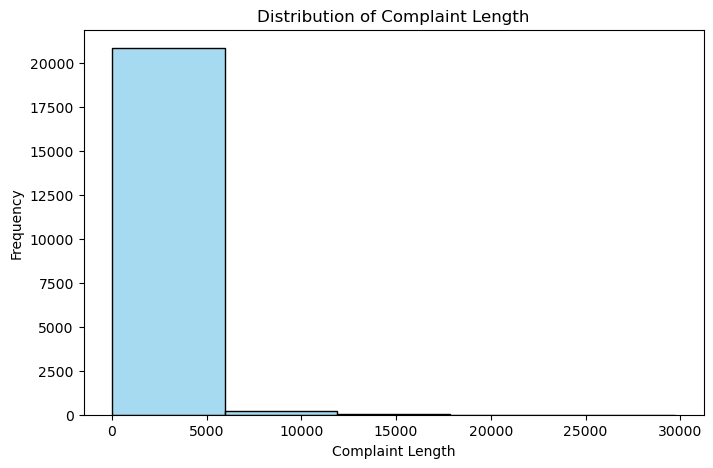

In [55]:
# Visualise the data according to the 'complaint' character length

# Calculate character length of each text entry
df_clean["complaint_length"] = df_clean["complaint"].apply(len)

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(df_clean["complaint_length"], bins=5, kde=False, color='skyblue')
plt.xlabel("Complaint Length")
plt.ylabel("Frequency")
plt.title("Distribution of Complaint Length")
plt.show()

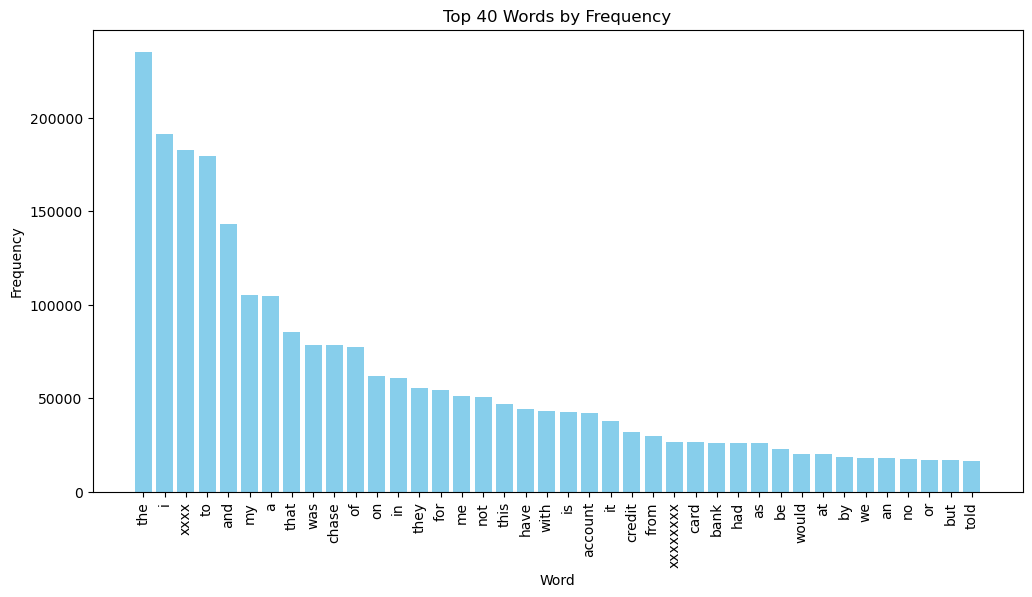

In [56]:
# Find the top 40 words by frequency among all the complaints after processing the text
all_words = [word for complaints in df_clean["complaint"] for word in complaints.split()]

# Get the top 40 most common words
word_freq = Counter(all_words).most_common(40)
(words, counts) = zip(*word_freq)

# Plot the top 40 most common words
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color="skyblue")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Top 40 Words by Frequency")
plt.xticks(rotation=90)
plt.show()

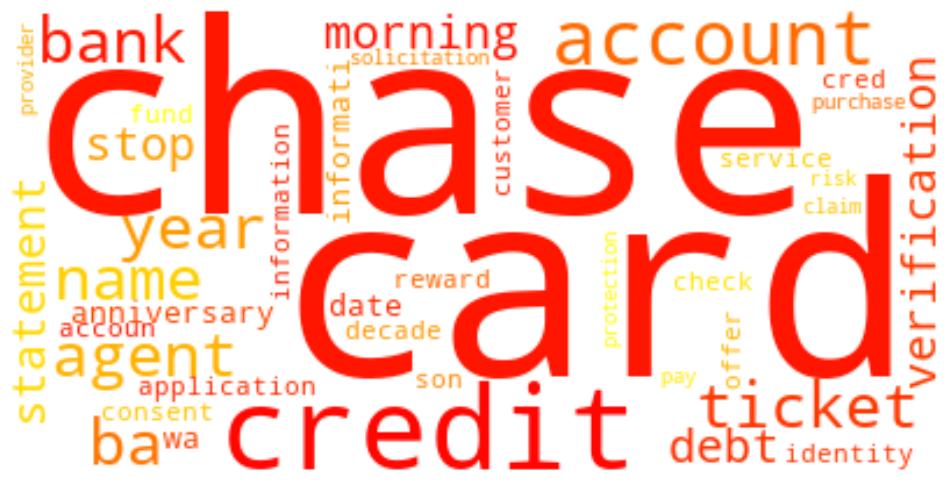

In [57]:
# Print word cloud for top 40 words using complaint pos removed data

wordcloud = WordCloud(max_words=40, random_state=42, colormap="autumn", background_color="white")
wordcloud.generate(str(df_clean['complaint_pos_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [58]:
# Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaint_pos_removed'].str.replace('-PRON-', '')
print_shape_and_5rows(df_clean)

Shape = (21072, 5)


,complaint,complaint_lemmatized,complaint_pos_removed,complaint_length,complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,469,morning name stop debt verification statement ...
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent wa informati...,334,card agent anniversary date agent wa informati...
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,209,card application identity consent service cred...
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,1424,ticket offer ticket reward card information of...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,452,son check chase account fund chase bank accoun...


In [59]:
# Find the top 30 unigram frequency among the complaints in the cleaned dataframe

# Apply preprocessing to all rows and flatten the list
unigram_words = [word for complaint in df_clean["complaint_clean"] for word in word_tokenize(complaint)]

# Get top 30 unigrams by frequency
counter_unigram_words = Counter(unigram_words)
unigram_freq = counter_unigram_words.most_common(30)

# Convert to DataFrame for better readability
unigram_df = pd.DataFrame(unigram_freq, columns=["Unigram", "Frequency"])
print(unigram_df.head(10))

   Unigram  Frequency
0    chase      58241
1  account      46232
2   credit      32022
3     card      29546
4  payment      20823
5     bank      20391
6     time      15677
7      day      12525
8    money      11810
9   charge      11802


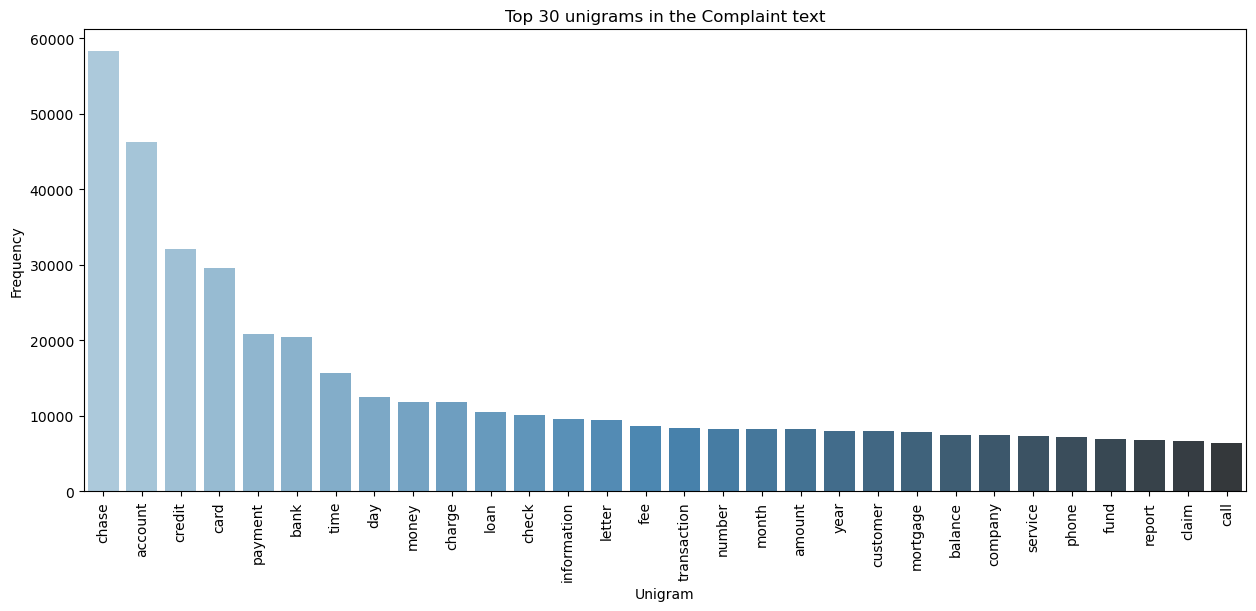

In [60]:
# Plot top 30 unigrams as bar plot

plt.figure(figsize=(15,6))
sns.barplot(x='Unigram', y='Frequency', data=unigram_df, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text")
plt.show()

In [61]:
# Defined a method to return ngrams for a given corpus of text
def get_ngrams(words, n=2):
    return list(nltk.ngrams(words, n))

In [62]:
# Find the top 30 bigram frequency among the complaints in the cleaned dataframe (df_clean)
bigram_words = [bigram for complaint in df_clean["complaint_clean"] for bigram in get_ngrams(word_tokenize(complaint), 2)]

# Get top 10 bigrams by frequency
counter_bigram_words = Counter(bigram_words)
bigram_freq = counter_bigram_words.most_common(30)

bigram_df = pd.DataFrame(bigram_freq, columns=["Bigram", "Frequency"])
bigram_df["Bigram"] = bigram_df["Bigram"].apply(lambda x: " ".join(x))
print(bigram_df.head(10))

             Bigram  Frequency
0       credit card      12591
1     credit report       3810
2     account chase       3505
3        chase bank       3463
4     chase account       3343
5      chase credit       3247
6  customer service       3019
7   account account       2537
8  checking account       2509
9      bank account       2450


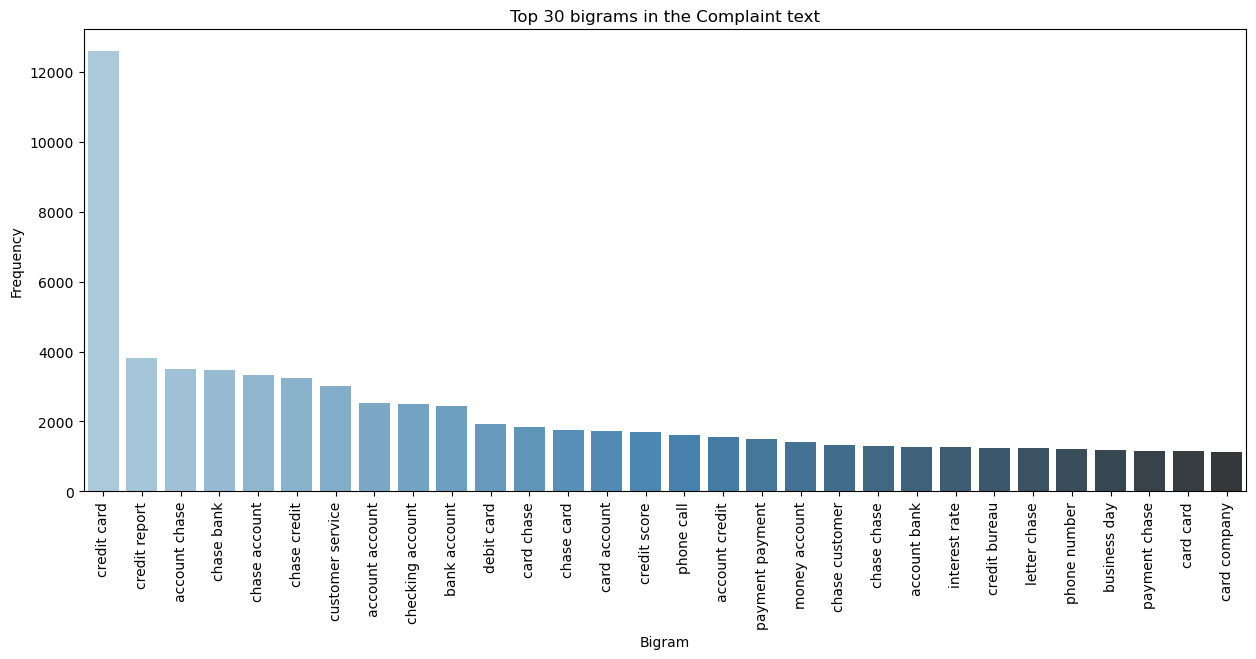

In [63]:
# Plot top 30 bigrams as bar plot

plt.figure(figsize=(15,6))
sns.barplot(x='Bigram', y='Frequency', data=bigram_df, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text")
plt.show()

In [64]:
# Find the top 30 trigram frequency among the complaints in the cleaned dataframe (df_clean)
trigram_words = [trigram for complaint in df_clean["complaint_clean"] for trigram in get_ngrams(word_tokenize(complaint), 3)]

# Get top 30 trigrams by frequency
counter_trigram_words = Counter(trigram_words)
trigram_freq = counter_trigram_words.most_common(30)

trigram_df = pd.DataFrame(trigram_freq, columns=["Trigram", "Frequency"])
trigram_df["Trigram"] = trigram_df["Trigram"].apply(lambda x: " ".join(x))
print(trigram_df.head(10))

                  Trigram  Frequency
0       chase credit card       2182
1     credit card account       1093
2     credit card company        978
3       credit card chase        821
4  chase customer service        610
5   inquiry credit report        550
6      credit card credit        530
7      chase bank account        440
8     account credit card        436
9        card credit card        435


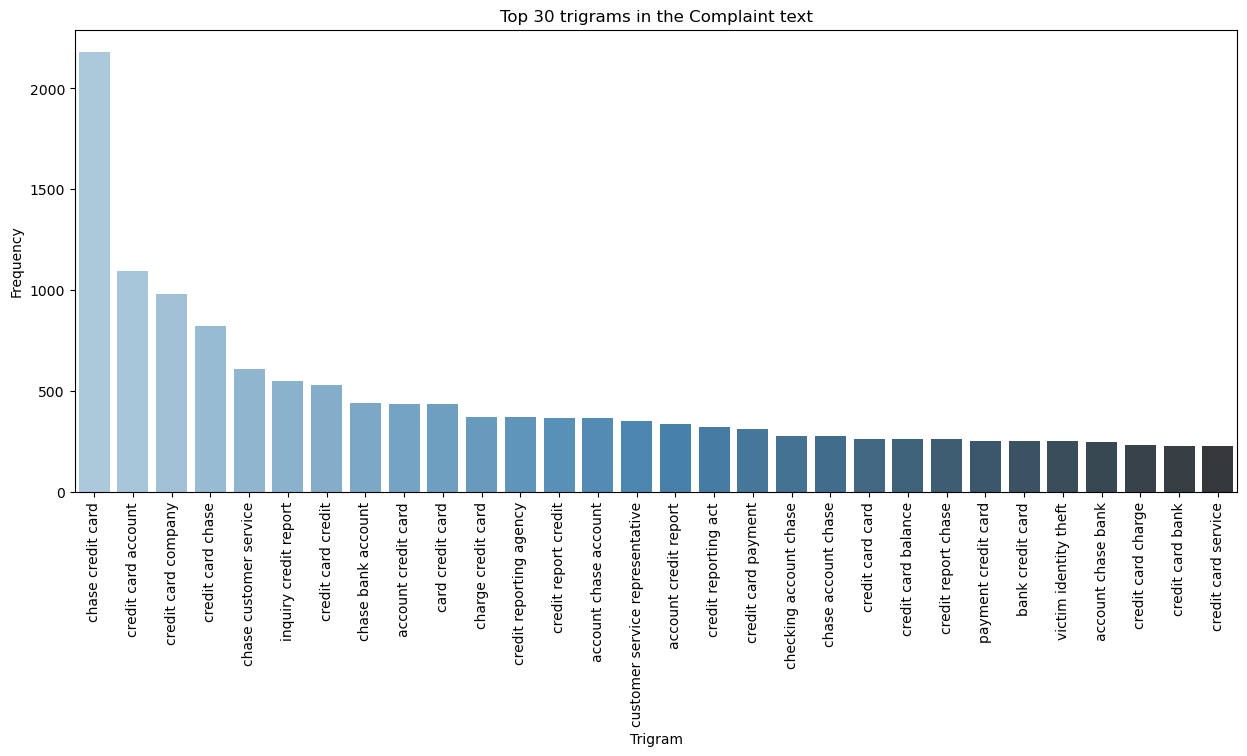

In [65]:
# Plot top 30 trigrams as bar plot

plt.figure(figsize=(15,6))
sns.barplot(x='Trigram', y='Frequency', data=trigram_df, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text")
plt.show()

# Feature Extraction

In [67]:
# Remove the masked text containing personal details of customer
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')
print_shape_and_5rows(df_clean)

Shape = (21072, 5)


,complaint,complaint_lemmatized,complaint_pos_removed,complaint_length,complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,469,morning name stop debt verification statement ...
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent wa informati...,334,card agent anniversary date agent wa informati...
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,209,card application identity consent service cred...
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,1424,ticket offer ticket reward card information of...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,452,son check chase account fund chase bank accoun...


In [68]:
# Initialise the TfidfVectorizer, max_df=0.95, min_df=2
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

In [69]:
# Create the Document Term Matrix by transforming the complaints column present in df_clean
data_X = tfidf.fit_transform(df_clean["complaint_clean"])

df_X = pd.DataFrame(data_X.toarray(), columns=tfidf.get_feature_names_out())
df_X

,aarp,abandonment,abatement,abide,ability,absence,absent,absurdity,abundance,abuse,...,yesterday,yield,yo,yoga,youth,yr,zip,zipcode,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.164863,0.0,0.0,0.0,0.0


# Topic Modelling

In [79]:
# Load nmf_model with the n_components i.e 10
num_topics = 10

nmf_model = NMF(n_components=num_topics, random_state=42)
W = nmf_model.fit_transform(data_X)
H = nmf_model.components_

In [87]:
# Print the Top 15 words for each of the topics

num_words = 15
words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, num_words)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(num_words)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:num_words]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,checking,reason,fund,deposit,balance,branch,chase,business,year,access,identity,activity,saving,bank
Topic 2,card,credit,chase,balance,score,limit,year,purchase,company,month,rate,freedom,point,application,reason
Topic 3,payment,month,balance,statement,day,credit,time,auto,date,chase,mortgage,error,car,bank,history
Topic 4,inquiry,report,credit,company,bureau,reporting,information,identity,score,debt,theft,authorization,creditor,act,application
Topic 5,loan,mortgage,home,modification,year,property,rate,foreclosure,house,document,sale,chase,time,income,tax
Topic 6,check,fund,deposit,bank,day,branch,hold,cashier,business,chase,money,teller,week,customer,manager
Topic 7,chase,letter,information,number,phone,service,email,customer,time,dispute,complaint,address,representative,day,issue
Topic 8,fee,overdraft,balance,transfer,year,chase,statement,customer,month,transaction,time,dollar,service,fund,day
Topic 9,charge,dispute,merchant,fraud,transaction,company,purchase,statement,card,claim,investigation,billing,item,visa,vendor
Topic 10,money,bank,transaction,claim,fund,atm,debit,day,fraud,transfer,person,branch,deposit,wire,withdrawal


In [90]:
# Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_mapping = {
    0: 'Account',
    1: 'Credit Card',
    2: 'Auto Mortgage',
    3: 'Credit Card',
    4: 'Home Mortgage',
    5: 'Other',
    6: 'Customer Dispute',
    7: 'Account',
    8: 'Fraud Transaction',
    9: 'Fraud Transaction',
}

In [92]:
# Assign the best topic to each of the cmplaints in Topic Column

W = pd.DataFrame(W, columns=[i for i in range(num_topics)])
df_clean['topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)

print_shape_and_5rows(df_clean)

Shape = (21072, 6)


,complaint,complaint_lemmatized,complaint_pos_removed,complaint_length,complaint_clean,topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,469,morning name stop debt verification statement ...,Customer Dispute
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent wa informati...,334,card agent anniversary date agent wa informati...,Credit Card
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,209,card application identity consent service cred...,Credit Card
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,1424,ticket offer ticket reward card information of...,Customer Dispute
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,452,son check chase account fund chase bank accoun...,Other


In [94]:
# Print the first 5 Complaint for each of the Topics
df_clean_topic = df_clean.groupby('topic').head(5)
df_clean_topic.sort_values('topic')

,complaint,complaint_lemmatized,complaint_pos_removed,complaint_length,complaint_clean,topic
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,notice account debit card branch customer serv...,2221,notice account debit card branch customer serv...,Account
10,mishandling of this account by chase auto and ...,mishandling of this account by chase auto and ...,account auto,50,account auto,Account
12,i opened an account with chase bank on xxxx an...,i opened an account with chase bank on xxxx an...,account bank code bonus term everything accoun...,401,account bank code bonus term everything accoun...,Account
13,to whom it may concern chase bank charged wron...,to whom it may concern chase bank charged wron...,concern overdraft fee alert balance unsuficent...,543,concern overdraft fee alert balance unsuficent...,Account
15,i opened the saving account for the bonus i wa...,i opened the saving account for the bonus i wa...,account bonus bonus auto transfer notice trans...,471,account bonus bonus auto transfer notice trans...,Account
33,i recently called to ask chase bank why they r...,i recently called to ask chase bank why they r...,credit bureau day payment info bill balance bi...,1302,credit bureau day payment info bill balance bi...,Auto Mortgage
73,a double payment from my chase debt cart to ch...,a double payment from my chase debt cart to ch...,payment chase debt cart credit card request da...,313,payment chase debt cart credit card request da...,Auto Mortgage
57,action taken by the company between the dates ...,action taken by the company between the date o...,action company date chase claim claim payment ...,5750,action company date chase claim claim payment ...,Auto Mortgage
7,during the summer months i experience a declin...,during the summer month i experience a decline...,summer month decline income employment month p...,1342,summer month decline income employment month p...,Auto Mortgage
24,i made a purchase of on xxxxxxxx i made paymen...,i made a purchase of on xxxxxxxx i made paymen...,purchase payment payment closing date xxxxxxxx...,1023,purchase payment payment closing date stateme...,Auto Mortgage


In [96]:
#Create the dictionary of Topic names and Topics

topic_names = {
    "Account": "Bank Account services",
    "Credit Card": "Credit card or prepaid card",
    "Fraud Transaction": "Theft/Dispute Reporting",
    "Customer Dispute": "Theft/Dispute Reporting",
    "Auto Mortgage": "Mortgage/Loan",
    "Home Mortgage": "Mortgage/Loan",
    "Other": "Others"
}

# Replace Topics with Topic Names
df_clean['topic'] = df_clean['topic'].map(topic_names)
print_shape_and_5rows(df_clean)

Shape = (21072, 6)


,complaint,complaint_lemmatized,complaint_pos_removed,complaint_length,complaint_clean,topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop debt verification statement ...,469,morning name stop debt verification statement ...,Theft/Dispute Reporting
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,card agent anniversary date agent wa informati...,334,card agent anniversary date agent wa informati...,Credit card or prepaid card
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,209,card application identity consent service cred...,Credit card or prepaid card
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket reward card information of...,1424,ticket offer ticket reward card information of...,Theft/Dispute Reporting
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase bank accoun...,452,son check chase account fund chase bank accoun...,Others


# Model Building

In [99]:
# Keep the columns complaint & topic only in the new dataframe --> training_data
training_data = df_clean[["complaint", "topic"]]
print_shape_and_5rows(training_data)

Shape = (21072, 2)


,complaint,topic
0,good morning my name is xxxx xxxx and i apprec...,Theft/Dispute Reporting
1,i upgraded my xxxx xxxx card in and was told b...,Credit card or prepaid card
2,chase card was reported on however fraudulent ...,Credit card or prepaid card
3,on while trying to book a xxxx xxxx ticket i c...,Theft/Dispute Reporting
4,my grand son give me check for i deposit it in...,Others


In [101]:
topic_names = {
    'Bank Account services': 0, 
    'Others': 1, 
    'Mortgage/Loan': 2, 
    'Credit card or prepaid card': 3, 
    'Theft/Dispute Reporting': 4
}
training_data['topic'] = training_data['topic'].map(topic_names)
print_shape_and_5rows(training_data)

Shape = (21072, 2)


,complaint,topic
0,good morning my name is xxxx xxxx and i apprec...,4
1,i upgraded my xxxx xxxx card in and was told b...,3
2,chase card was reported on however fraudulent ...,3
3,on while trying to book a xxxx xxxx ticket i c...,4
4,my grand son give me check for i deposit it in...,1


In [103]:
# Get the word vector and transform it to tf-idf
count_vector = CountVectorizer(stop_words="english")
X_count = count_vector.fit_transform(training_data["complaint"])

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_count)

# Split the file tfidf training data to train and test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, training_data["topic"], test_size=0.2, random_state=42)

In [105]:
# Define a function to print various metrics comparing the actual and prediction
model_metrics = pd.DataFrame(columns = ["model", "confusion_matrix", "accuracy_score", "precision_score", "recall_score", 
                                        "f1_score"])

def print_metrics(model, actual, prediction, model_metrics):
    classification_report = metrics.classification_report(y_true=actual, y_pred=prediction)
    print("Classification Report = \n", classification_report)
    
    confusion_matrix = metrics.confusion_matrix(actual, prediction)
    print("Confusion Matrix = \n", confusion_matrix)

    accuracy_score = round(metrics.accuracy_score(actual, prediction), 2)
    print("Accuracy score =", accuracy_score)

    precision_score = round(metrics.precision_score(actual, prediction, average="weighted"), 2)
    print("Precision score =", precision_score)

    recall_score = round(metrics.recall_score(actual, prediction, average="weighted"), 2)
    print("Recall score =", recall_score)

    f1_score = round(metrics.f1_score(actual, prediction, average="weighted"), 2)
    print("F1 score =", f1_score)

    model_metrics.loc[len(model_metrics)] = (model, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
                                            )
    return model_metrics

## Logistic Regression

In [108]:
# Build logistic regression model
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)

LogisticRegression()

In [109]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model
y_train_pred = logistic_reg.predict(X_train)
y_train_pred = pd.DataFrame({ 'topic': y_train, 'topic_predicted': y_train_pred, 'id': y_train.index })
y_train_pred

,topic,topic_predicted,id
285,2,2,285
8049,3,3,8049
10520,3,3,10520
6225,1,1,6225
549,0,0,549
...,...,...,...
11284,2,2,11284
11964,4,4,11964
5390,2,2,5390
860,0,0,860


In [110]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Logistic Regression (Training Data)', 
                              y_train_pred.topic, 
                              y_train_pred.topic_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.93      0.90      0.91      2624
           1       0.98      0.91      0.95      1197
           2       0.96      0.96      0.96      4002
           3       0.94      0.94      0.94      3821
           4       0.91      0.94      0.93      5213

    accuracy                           0.94     16857
   macro avg       0.95      0.93      0.94     16857
weighted avg       0.94      0.94      0.94     16857

Confusion Matrix = 
 [[2351    3   42   60  168]
 [  28 1090   13    8   58]
 [  20    2 3856   46   78]
 [  33    0   32 3603  153]
 [  97   13   73  115 4915]]
Accuracy score = 0.94
Precision score = 0.94
Recall score = 0.94
F1 score = 0.94


In [111]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model for testing data
y_test_pred = logistic_reg.predict(X_test)
y_test_pred = pd.DataFrame({ 'topic': y_test, 'topic_predicted': y_test_pred, 'id': y_test.index })
y_test_pred

,topic,topic_predicted,id
10796,1,1,10796
16441,4,4,16441
16623,2,2,16623
12833,0,0,12833
14844,4,4,14844
...,...,...,...
1776,2,2,1776
16266,2,0,16266
12363,3,3,12363
7476,3,3,7476


In [112]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Logistic Regression (Testing Data)', 
                              y_test_pred.topic, 
                              y_test_pred.topic_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.84      0.78      0.81       619
           1       0.95      0.86      0.91       288
           2       0.92      0.91      0.92       956
           3       0.88      0.88      0.88       987
           4       0.85      0.90      0.88      1365

    accuracy                           0.88      4215
   macro avg       0.89      0.87      0.88      4215
weighted avg       0.88      0.88      0.88      4215

Confusion Matrix = 
 [[ 484    8   21   37   69]
 [   9  248   10    4   17]
 [  17    0  873   20   46]
 [  21    0   19  864   83]
 [  45    4   29   52 1235]]
Accuracy score = 0.88
Precision score = 0.88
Recall score = 0.88
F1 score = 0.88


## Decision Tree

In [114]:
# Build decision tree model
decision_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [115]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model
y_train_pred = decision_tree.predict(X_train)
y_train_pred = pd.DataFrame({ 'topic': y_train, 'topic_predicted': y_train_pred, 'id': y_train.index })
y_train_pred

,topic,topic_predicted,id
285,2,2,285
8049,3,3,8049
10520,3,3,10520
6225,1,1,6225
549,0,0,549
...,...,...,...
11284,2,2,11284
11964,4,4,11964
5390,2,2,5390
860,0,0,860


In [116]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Decision Tree (Training Data)', 
                              y_train_pred.topic, 
                              y_train_pred.topic_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.83      0.69      0.75      2624
           1       0.88      0.80      0.84      1197
           2       0.89      0.87      0.88      4002
           3       0.80      0.81      0.81      3821
           4       0.73      0.81      0.77      5213

    accuracy                           0.80     16857
   macro avg       0.82      0.80      0.81     16857
weighted avg       0.81      0.80      0.80     16857

Confusion Matrix = 
 [[1799   52   64  155  554]
 [  23  963   27   39  145]
 [  59   26 3484  113  320]
 [  66    5   88 3109  553]
 [ 215   54  251  483 4210]]
Accuracy score = 0.8
Precision score = 0.81
Recall score = 0.8
F1 score = 0.8


In [117]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model for testing data
y_test_pred = decision_tree.predict(X_test)
y_test_pred = pd.DataFrame({ 'topic': y_test, 'topic_predicted': y_test_pred, 'id': y_test.index })
y_test_pred

,topic,topic_predicted,id
10796,1,1,10796
16441,4,3,16441
16623,2,2,16623
12833,0,0,12833
14844,4,4,14844
...,...,...,...
1776,2,2,1776
16266,2,2,16266
12363,3,3,12363
7476,3,3,7476


In [118]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Decision Tree (Testing Data)', 
                              y_test_pred.topic, 
                              y_test_pred.topic_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.70      0.58      0.63       619
           1       0.83      0.77      0.80       288
           2       0.85      0.82      0.83       956
           3       0.73      0.78      0.75       987
           4       0.71      0.75      0.73      1365

    accuracy                           0.75      4215
   macro avg       0.76      0.74      0.75      4215
weighted avg       0.75      0.75      0.75      4215

Confusion Matrix = 
 [[ 356   20   29   65  149]
 [  13  222    8   15   30]
 [  23    7  785   40  101]
 [  33    1   39  767  147]
 [  86   19   66  168 1026]]
Accuracy score = 0.75
Precision score = 0.75
Recall score = 0.75
F1 score = 0.75


## Random Forest

In [120]:
# Build decision tree model
random_forest = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, random_state=42)

In [121]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model
y_train_pred = random_forest.predict(X_train)
y_train_pred = pd.DataFrame({ 'topic': y_train, 'topic_predicted': y_train_pred, 'id': y_train.index })
y_train_pred

,topic,topic_predicted,id
285,2,4,285
8049,3,3,8049
10520,3,4,10520
6225,1,4,6225
549,0,0,549
...,...,...,...
11284,2,2,11284
11964,4,4,11964
5390,2,2,5390
860,0,2,860


In [122]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Random Forest (Training Data)', 
                              y_train_pred.topic, 
                              y_train_pred.topic_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.99      0.46      0.62      2624
           1       1.00      0.49      0.66      1197
           2       0.94      0.92      0.93      4002
           3       0.88      0.87      0.88      3821
           4       0.68      0.97      0.80      5213

    accuracy                           0.82     16857
   macro avg       0.90      0.74      0.78     16857
weighted avg       0.86      0.82      0.81     16857

Confusion Matrix = 
 [[1196    0  112  267 1049]
 [   7  590   50   19  531]
 [   1    0 3664   70  267]
 [   0    0   18 3314  489]
 [   3    0   58   75 5077]]
Accuracy score = 0.82
Precision score = 0.86
Recall score = 0.82
F1 score = 0.81


In [123]:
# Prepare dataframe containing actual topic and predicted topic obtained from the model for testing data
y_test_pred = random_forest.predict(X_test)
y_test_pred = pd.DataFrame({ 'topic': y_test, 'topic_predicted': y_test_pred, 'id': y_test.index })
y_test_pred

,topic,topic_predicted,id
10796,1,2,10796
16441,4,4,16441
16623,2,2,16623
12833,0,0,12833
14844,4,4,14844
...,...,...,...
1776,2,2,1776
16266,2,4,16266
12363,3,3,12363
7476,3,3,7476


In [129]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Random Forest (Testing Data)', 
                              y_test_pred.topic, 
                              y_test_pred.topic_predicted, 
                              model_metrics)

Classification Report = 
               precision    recall  f1-score   support

           0       0.88      0.17      0.28       619
           1       0.93      0.15      0.26       288
           2       0.82      0.83      0.83       956
           3       0.78      0.73      0.76       987
           4       0.58      0.92      0.72      1365

    accuracy                           0.69      4215
   macro avg       0.80      0.56      0.57      4215
weighted avg       0.75      0.69      0.66      4215

Confusion Matrix = 
 [[ 103    3   60   99  354]
 [   5   43   25    5  210]
 [   4    0  797   46  109]
 [   0    0   38  725  224]
 [   5    0   48   53 1259]]
Accuracy score = 0.69
Precision score = 0.75
Recall score = 0.69
F1 score = 0.66


# Model Inference

In [141]:
# Print a comparison of all the above models along with the various scores
model_metrics

,model,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
0,Logistic Regression (Training Data),"[[2351, 3, 42, 60, 168], [28, 1090, 13, 8, 58]...",0.94,0.94,0.94,0.94
1,Logistic Regression (Testing Data),"[[484, 8, 21, 37, 69], [9, 248, 10, 4, 17], [1...",0.88,0.88,0.88,0.88
2,Decision Tree (Training Data),"[[1799, 52, 64, 155, 554], [23, 963, 27, 39, 1...",0.80,0.81,0.80,0.80
3,Decision Tree (Testing Data),"[[356, 20, 29, 65, 149], [13, 222, 8, 15, 30],...",0.75,0.75,0.75,0.75
4,Random Forest (Training Data),"[[1196, 0, 112, 267, 1049], [7, 590, 50, 19, 5...",0.82,0.86,0.82,0.81
5,Random Forest (Testing Data),"[[103, 3, 60, 99, 354], [5, 43, 25, 5, 210], [...",0.69,0.75,0.69,0.66


In [143]:
# Set the finally selected model (logistic regression)
final_model = logistic_reg

In [147]:
# Some sample complaints to infer model
df_complaints = pd.DataFrame({'complaints': [
    "I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
    "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
    "I want to open a salary account at your downtown branch. Please provide me the procedure.",
    "Yesterday, I received a fraudulent email regarding renewal of my services.",
    "What is the procedure to know my CIBIL score?",
    "I need to know the number of bank branches and their locations in the city of Dubai"
]})
df_complaints

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [149]:
# Method to transform text, and predict the topic name as it
topic_names = {
    0: 'Bank Account services', 
    1: 'Others',
    2: 'Mortgage/Loan',
    3: 'Credit card or prepaid card',
    4: 'Theft/Dispute Reporting'
}

def predict_complaint(text):
    text_count = count_vector.transform(text)
    text_tfidf = tfidf_transformer.transform(text_count)
    predicted = final_model.predict(text_tfidf)
    return topic_names[predicted[0]]

In [151]:
# Predict topic against each complaint and print the final output
df_complaints['topic'] = df_complaints['complaints'].apply(lambda x: predict_complaint([x]))
df_complaints

,complaints,topic
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Credit card or prepaid card
2,I want to open a salary account at your downto...,Bank Account services
3,"Yesterday, I received a fraudulent email regar...",Theft/Dispute Reporting
4,What is the procedure to know my CIBIL score?,Mortgage/Loan
5,I need to know the number of bank branches and...,Theft/Dispute Reporting
